In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Bright sources from 1-dimensional coded mask 

This is the code we'll need:

In [2]:
from sympy.ntheory.primetest import isprime
from scipy.linalg import hankel

def linear_ura(L):
    assert(((L - 3) / 4).is_integer())
    assert(isprime(L))
    A = np.zeros(L)
    G = np.ones(L) # decoding
    A[np.unique(np.mod(np.arange(L) ** 2, L))] = 1
    G[A == 0] = -1
    return A, G

def _pad(A):
    n = int(len(A)/2)
    return np.concatenate((A[-n:], A, A[:n]))

def autocorr(A, G):
    assert(len(A) == len(G))
    _A, _G = _pad(A), _pad(G)
    n = len(A)
    hankel_ura_mask = hankel(_A[:n], _A[n - 1:])
    hankel_decoding = hankel(_G[:n], _G[n - 1:])
    return np.dot(hankel_ura_mask, hankel_decoding)

def detector(A, source):
    assert(len(A) == len(source))
    _A = _pad(A)
    n = len(A)
    hankel_ura_mask = hankel(_A[:n], _A[n - 1:])
    return hankel_ura_mask.dot(source)

def decode(G, detector):
    assert(len(G) == len(detector))
    _G = _pad(G)
    n = len(G)
    norm = np.sum(G[G==1])
    hankel_ura_decoding = hankel(_G[:n], _G[n - 1:])
    return hankel_ura_decoding.dot(detector) / norm

The simulation idea is this:

1. Build the mask. We implement a linear, cyclic URA aperture mask from a sequence with size `mask_size`, according the geometry of Gottesman 2007. This implies that the aperture mask will have appropriate padding resulting in dimension `2*mask_size - 1`.
2. Simulate the background. We sample `nbackground` random integers between `0` and `mask_size`. These represents random directions.  For each background event a `1` is added to a `source` array with length `mask_size` at the appropriate direction-index. 
3. Simulate a bright source. For some `source_dir` integer chosen at random between `0` and `mask_size` we set `source[source_dir]` to `nsignal`. We fine tune the source count intensity `nsignal` so that we know in advance that it's significance exceeds a certain threshold (expressed in standard deviations, we'll use 5.5 sigma).
4. Generate the detector image. We generate the detector image correlating the aperture mask and the source according $D = A * S $.
5. Decode the detector image and implement a statistical test to retrieve the bright source location in the sky. The statistical test must know nothing of what we did at point 3. We attempt to "discover" point 3.

In [11]:
from scipy.stats import poisson, norm

mask_size = 263
bkg_rate = 100
nbackground = bkg_rate * mask_size
nsignal = poisson(bkg_rate).isf(1 - norm.cdf(5.5))

aperture, decoding = linear_ura(mask_size) 
background, _ = np.histogram(
    np.random.randint(mask_size, size = nbackground), 
    bins=np.arange(mask_size + 1)
)
source = background[:]
source_dir = np.random.randint(mask_size)
print(f"generated a bright source at sky direction index {source_dir}")
source[source_dir] = nsignal

generated a bright source at sky direction index 5


The detector image:

In [12]:
det = detector(aperture, source)

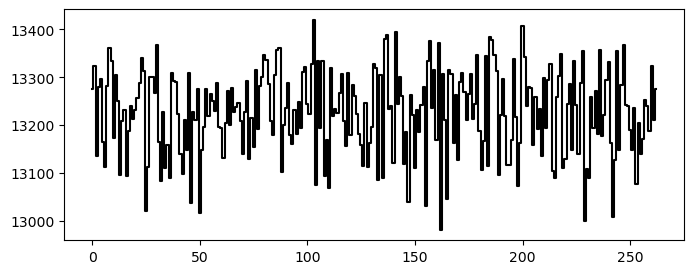

In [49]:
plt.figure(figsize = (8,3))
plt.step(np.arange(mask_size), detector(aperture, source), color='k', where='mid')
plt.show()

Awful. Now to the decoding.

In [55]:
decoded_image = decode(decoding, det)

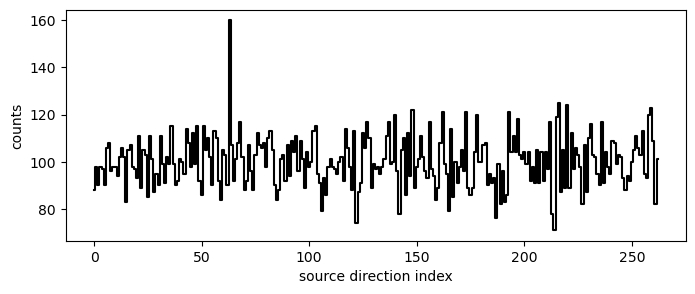

In [56]:
plt.figure(figsize = (8,3))
plt.step(np.arange(mask_size), decoded_image, color='k', where='mid')
plt.ylabel("counts")
plt.xlabel("source direction index")
plt.show()

Better. Note that the values in the plot just above are counts.
This fact allows us to implement a test of the hypothesis:

1. No source from direction $i$: $n_i \sim P(\lambda)$.
2. Bright source at direction $i$: $n_i \sim P(\mu \lambda)$ with $\mu > 1$.

Where $\lambda$ is the background rate, $P$ represents the Poisson distribution and $\mu$ is an intensity factor.
We'll repeat this test over all possible source directions $i$.

The loglikelihood ratio is:

$$
    2 \log\Big[\frac{L(Y  \mid H_1)}{L(Y  \mid H_0)}\Big] = 2\Big[n_i \log\Big(\frac{n_i}{\lambda}\Big) - (n_i - \lambda)\Big]
$$

Since the only parameter in our test is the source's intensity $\mu$, we can assess the significance of the excess in count from a particular direction through Wilk's theorem. Wilk's theorem states that the loglikelihood ratio is approximated by a $\chi^2$ distribution with one degree of freedom, which is the same distribution of $x^2$ where $x \sim N(0,1)$ is normally distributed . This imply that the significance of the excess of count from one of the directions in units of normal standard deviations is: 

$$
    S_i = \sqrt{2\Big[n_i \log\Big(\frac{n_i}{\lambda}\Big) - (n_i - \lambda)\Big]}
$$

Which we compute:

In [57]:
S = np.sqrt(2 * (decoded_image * np.log(decoded_image / bkg_rate) - (decoded_image - bkg_rate)))

The line above will fuck up whenever `decoded_image == 0` which can certainly happen when counts per detector unit are few. The issue is easy to fix: don't test for count excess if you source location is at or below the background level. I keep the line because it's nice.

Now we set a significance threshold and look for sources more significant than that:

In [58]:
threshold = 5 # sigma

if S[S > threshold]:
    for location in np.argwhere(S > 5)[0]:
        print(f"A source bright enough is apparent at sky location index {location} with significance {S[location]:.2f} sigma")

A source bright enough is apparent at sky location index 63 with significance 5.51 sigma


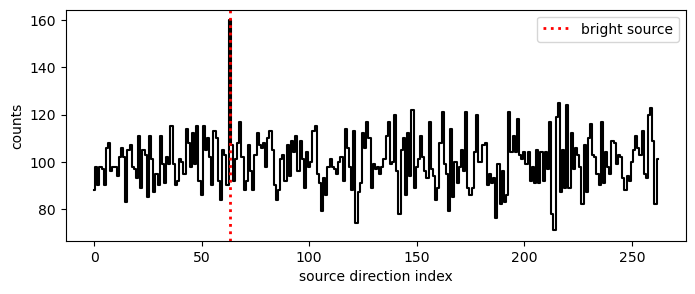

In [59]:
plt.figure(figsize = (8,3))
plt.step(np.arange(mask_size), decoded_image, color='k', where='mid')
if S[S > threshold]:
    for trig in np.argwhere(S > 5)[0]:
        plt.axvline(trig, linestyle="dotted", color = "red", linewidth=2, label="bright source")
plt.ylabel("counts")
plt.xlabel("source direction index")
plt.legend()
plt.show()

# Conclusions:

* Through decoding and normalization we get a map of the counts from all sky locations the detector is exposed to. This map is free of artifacts.
* Given the map, implementing a likelihood ratio test is straightforward if the background count rate is known in advance or we can estimate it.
